<a href="https://colab.research.google.com/github/Ekaterina-Kostina/study/blob/ML/hw3_Kostina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Загрузите датасет для бинарной или многоклассовой классификации:
Пример: обзоры фильмов с разметкой тональности в формате *.csv

In [8]:
!pip install datasets

In [9]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/sentiment140")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(dataset["train"])
print(df.head())

                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                           date             user  sentiment     query  
0  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_          0  NO_QUERY  
1  Mon Apr 06 22:19:49 PDT 2009    scotthamilton          0  NO_QUERY  
2  Mon Apr 06 22:19:53 PDT 2009         mattycus          0  NO_QUERY  
3  Mon Apr 06 22:19:57 PDT 2009          ElleCTF          0  NO_QUERY  
4  Mon Apr 06 22:19:57 PDT 2009           Karoli          0  NO_QUERY  


In [11]:
df

,text,date,user,sentiment,query
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,0,NO_QUERY
1,is upset that he can't update his Facebook by ...,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,0,NO_QUERY
2,@Kenichan I dived many times for the ball. Man...,Mon Apr 06 22:19:53 PDT 2009,mattycus,0,NO_QUERY
3,my whole body feels itchy and like its on fire,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,0,NO_QUERY
4,"@nationwideclass no, it's not behaving at all....",Mon Apr 06 22:19:57 PDT 2009,Karoli,0,NO_QUERY
...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,4,NO_QUERY
1599996,TheWDB.com - Very cool to hear old Walt interv...,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,4,NO_QUERY
1599997,Are you ready for your MoJo Makeover? Ask me f...,Tue Jun 16 08:40:49 PDT 2009,bpbabe,4,NO_QUERY
1599998,Happy 38th Birthday to my boo of alll time!!! ...,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,4,NO_QUERY


# 2. Выполните препроцессинг:
- Чистка данных методами NLP (регулярки, удаление стоп-слов и т.д.) и Data
Science (удаление пустых строк с помощью pd.dropna())
- Токенизация + векторизация (преобразование текстов к виду числовых представлений), например, с помощью токенизатора TensorFlow/Keras или PyTorch
- Паддинг/усечение (транкейшн) текстовых последовательностей
- Разделение датасета на обучающую, проверочную и тестовую выборки

In [12]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1600000 non-null  object
 1   date       1600000 non-null  object
 2   user       1600000 non-null  object
 3   sentiment  1600000 non-null  int64 
 4   query      1600000 non-null  object
dtypes: int64(1), object(4)
memory usage: 61.0+ MB
text         0
date         0
user         0
sentiment    0
query        0
dtype: int64


Нам нужны только два столбца:

1. text (текст твита) — входные данные
2. sentiment (метка класса) — целевая переменная


Остальные столбцы можно удалить, так как они не влияют на анализ текста

In [13]:
df.drop(columns=['date', 'user', 'query'], inplace=True)
df.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [14]:
import requests
import nltk
import spacy
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.tokenize import sent_tokenize, word_tokenize
import re

In [15]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

print(df['text'].head())

0    A thats a bummer You shoulda got David Carr of...
1    is upset that he cant update his Facebook by t...
2    I dived many times for the ball Managed to sav...
3       my whole body feels itchy and like its on fire
4    no its not behaving at all im mad why am i her...
Name: text, dtype: object


In [16]:
# Преобразуем весь столбец в нижний регистр
df['text'] = df['text'].apply(lambda x: x.lower())

print(df['text'].head())


0    a thats a bummer you shoulda got david carr of...
1    is upset that he cant update his facebook by t...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no its not behaving at all im mad why am i her...
Name: text, dtype: object


In [17]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['text'] = df['text'].apply(lambda x: x.split())  # Разбиваем текст на токены
df['text'] = df['text'].apply(remove_stopwords)  # Удаляем стоп-слова
df['text'] = df['text'].apply(lambda x: " ".join(x))  # Преобразуем обратно в строки

print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  sentiment
0      thats bummer shoulda got david carr third day          0
1  upset cant update facebook texting might cry r...          0
2  dived many times ball managed save 50 rest go ...          0
3                   whole body feels itchy like fire          0
4                           behaving im mad cant see          0


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Создаем токенизатор
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")  # num_words - количество слов в словаре

# Токенизируем текст
tokenizer.fit_on_texts(df['text'])

# Преобразуем текст в последовательности индексов
X = tokenizer.texts_to_sequences(df['text'])

# Паддинг последовательностей до одинаковой длины
max_length = 50
X_pad = pad_sequences(X, maxlen=max_length, padding='post', truncating='post')

# Проверяем результат
print("Пример последовательности после паддинга:")
print(X_pad[42])


Пример последовательности после паддинга:
[ 47  47  47   8  20  76 107  92  52  24  12   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_pad, df['sentiment'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Проверим размеры выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (1280000, 50)
Размер валидационной выборки: (160000, 50)
Размер тестовой выборки: (160000, 50)


In [34]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Проверим уникальные значения
print(np.unique(y_train))

[0 1]


# 3. Постройте модель CNN:
Добавьте входной слой

Добавьте слои свертки и пулинга

Настройте размер ядра свертки

Добавьте полносвязные слой

Настройте функции активации для промежуточных и выходных слоев

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

model = Sequential()
model.add(Embedding(input_dim=50000, output_dim=128, input_length=50))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Для бинарной классификации


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# 4. Скомпилируйте модель:

Настройте функцию потерь, оптимизатор укажите метрики оценки для валидации модели в процессе обучения

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 5. Обучите модель:
- Введите данные в модель
- Добавьте отслеживание потерь/точности обучения

In [37]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7528 - loss: 0.4930 - val_accuracy: 0.7954 - val_loss: 0.4382
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 143s 5ms/step - accuracy: 0.8112 - loss: 0.4109 - val_accuracy: 0.7989 - val_loss: 0.4324
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 138s 5ms/step - accuracy: 0.8403 - loss: 0.3600 - val_accuracy: 0.7920 - val_loss: 0.4478
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 148s 5ms/step - accuracy: 0.8761 - loss: 0.2935 - val_accuracy: 0.7848 - val_loss: 0.5013
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - accuracy: 0.9047 - loss: 0.2318 - val_accuracy: 0.7772 - val_loss: 0.5702
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 136s 5ms/step - accuracy: 0.9244 - loss: 0.1866 - val_accuracy: 0.7620 - val_loss: 0.6813
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.9360 - loss: 0.1564 - val_accuracy: 0.7594 - val_loss: 0.7826
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - acc

# 6. Оцените модель:
- Проверьте модель на тестовом наборе
- Вычислите метрики оценки (например, полноту, точность, F1-меру)
- Выполните визуализацию результатов (например, с помощью матрицы ошибок)
- Произведите настройку параметров

In [38]:
# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7544 - loss: 1.0179
Test accuracy: 75.42%


In [39]:
from sklearn.metrics import classification_report, confusion_matrix

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Переводим вероятности в метки классов
y_pred = (y_pred > 0.5).astype(int)

# Генерация отчета с метриками
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Генерация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     79807
           1       0.76      0.75      0.75     80193

    accuracy                           0.75    160000
   macro avg       0.75      0.75      0.75    160000
weighted avg       0.75      0.75      0.75    160000

Confusion Matrix:
[[60404 19403]
 [19921 60272]]


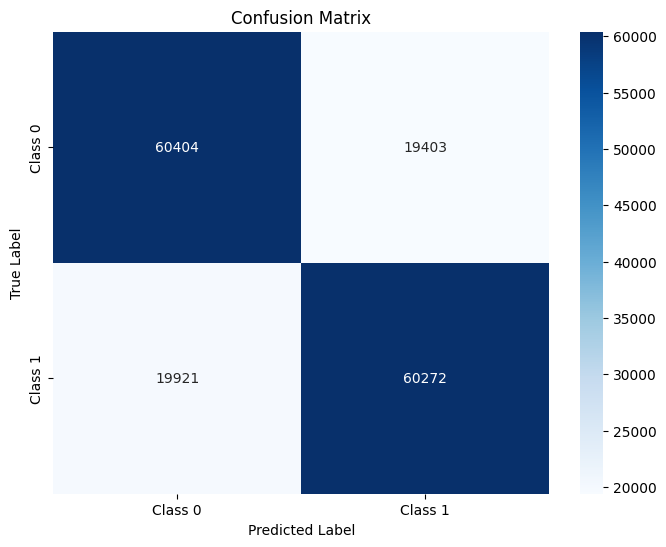

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Визуализация матрицы ошибок
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Aaccuracy 75,4%

F1-меры: 0.75 для каждого класса

In [1]:
!pip install scikeras

from scikeras.wrappers import KerasClassifier

In [21]:
# Попробуем использовать метод GridSearchCV для настройки параметров
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=X_train.shape[1], output_dim=128, input_length=X_train.shape[1]))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Оборачиваем модель в KerasRegressor
model = KerasRegressor(model=create_model, epochs=25, batch_size=1, verbose=2)

# Определяем параметры для GridSearch
param_grid = {
    'batch_size': [32, 64],
    'epochs': [5, 10],
    'optimizer': ['adam', 'rmsprop'],
}

# Применяем GridSearch
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Выводим результаты
print("Лучшие параметры: ", grid_search.best_params_)
print("Лучший результат: ", grid_search.best_score_)



AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Почему-то у меня не получается настроить никакие параметры... Я уже попробовала GridSearchCV и RandomizedSearchCV, но все равно не получилось

# 7. Добавьте комментарии:
- какие настройки вы изменили и почему? Обоснуйте выбор параметров.
- Сохраните модель
https://www.tensorflow.org/tutorials/keras/save_and_load

Я меняла настройки Learning rate и batch size вручную. На LR 0,001 модель переобучалась, а при LR = 0,0001 вроде все оказалось нормальным. Batch size 64 мне показался наиболее оптимальным, 128 — слишком мелкий, 32 — слишком крупный.

Другие гиперпараметры не получилось настроить автоматически. Была идея вручную это сделать с помощью циклов вместо KerasClassifier (у меня вылетала такая ошибка: ModuleNotFoundError: No module named 'keras.wrappers'), но я не дошла до этого...

In [43]:
pip install pyyaml h5py  # Required to save models in HDF5 format

In [45]:
model.save("my_model.h5")